In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
 
from sklearn.metrics import mean_absolute_error, mean_squared_error,  r2_score, explained_variance_score
from MyFuns import adj_r2

In [2]:
#read in csv to df
df = pd.read_csv('./data/1917_full.csv', encoding='utf-16')
df.head()

,Year,Month,Stn_Name,Prov,Lat,Long,Tm,S,P
0,1917,1,ALIX,AB,52.383,-113.167,-15.400000,40.200001,42.000000
1,1917,1,ALLIANCE,AB,52.433,-111.783,-17.299999,0.000000,0.000000
2,1917,1,ATHABASCA LANDING,AB,54.717,-113.283,-20.700001,26.400000,26.400000
3,1917,1,BANFF,AB,51.183,-115.567,-11.400000,18.299999,18.299999
4,1917,1,BASHAW,AB,52.683,-112.867,0.000000,22.900000,35.599998


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5979 entries, 0 to 5978
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5979 non-null   int64  
 1   Month     5979 non-null   int64  
 2   Stn_Name  5979 non-null   object 
 3   Prov      5979 non-null   object 
 4   Lat       5967 non-null   float64
 5   Long      5967 non-null   float64
 6   Tm        5979 non-null   float64
 7   S         5979 non-null   float64
 8   P         5979 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 420.5+ KB


In [4]:
#choose our target - I went with snowfall since it's directly correlated with the month, temperature and location
X = df.drop('S', axis=1)
y = df['S']

In [5]:
#convert object columns to numerical for regression
le = LabelEncoder()
X['Prov'] = le.fit_transform(X['Prov'])
X['Stn_Name'] = le.fit_transform(X['Stn_Name'])
X.head()

,Year,Month,Stn_Name,Prov,Lat,Long,Tm,P
0,1917,1,5,0,52.383,-113.167,-15.400000,42.000000
1,1917,1,7,0,52.433,-111.783,-17.299999,0.000000
2,1917,1,22,0,54.717,-113.283,-20.700001,26.400000
3,1917,1,28,0,51.183,-115.567,-11.400000,18.299999
4,1917,1,35,0,52.683,-112.867,0.000000,35.599998


In [6]:
#split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
#fit the model to the training data
mdl = RandomForestRegressor()
mdl.fit(X_train,y_train)

RandomForestRegressor()

In [8]:
#predict on the test set
y_pred = mdl.predict(X_test)
y_pred[0:5]

array([ 0.        ,  2.10599997,  0.328     ,  0.        , 41.59299934])

In [9]:
#check our metrics
mean_absolute_error(y_pred, y_test)

4.808729076522714

In [10]:
np.sqrt(mean_squared_error(y_pred, y_test))

np.float64(11.128328605214385)

In [11]:
r2_score(y_pred, y_test)

0.788537307224258

In [12]:
adj_r2(r2_score(y_pred, y_test), len(y), len(X.columns))

0.7882539401317612

In [13]:
#some more metrics and plotting
eval_df = pd.DataFrame({'Actuals':y_test, 'Preds':y_pred})
eval_df['diff'] = np.abs(eval_df['Actuals'] - eval_df['Preds'])
eval_df['residuals'] = eval_df['Actuals'] - eval_df['Preds']
eval_df.head()

,Actuals,Preds,diff,residuals
4080,0.0,0.000000,0.000000,0.000000
5010,0.0,2.106000,2.106000,-2.106000
4833,0.0,0.328000,0.328000,-0.328000
2795,0.0,0.000000,0.000000,0.000000
167,35.5,41.592999,6.092999,-6.092999


In [14]:
eval_df.mean()

Actuals      15.700390
Preds        16.105091
diff          4.808729
residuals    -0.404701
dtype: float64

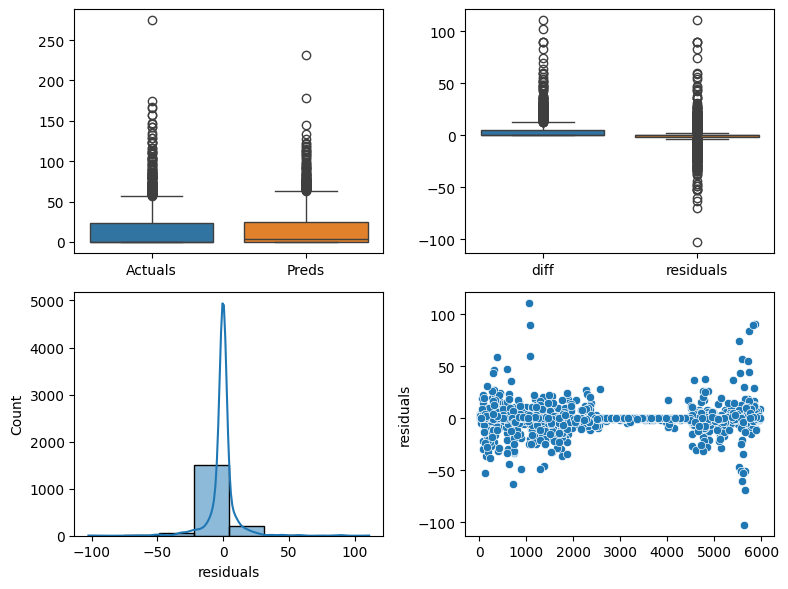

In [15]:
#we have most residuals very close to 0, but nonetheless have quite a few outliers
#the distribution of the residuals does not seem uniform/random so they are probably not independent
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
sns.boxplot(data=eval_df[['Actuals','Preds']], ax=axes[0,0])
sns.boxplot(data=eval_df[['diff','residuals']], ax=axes[0,1])
sns.histplot(data=eval_df['residuals'], kde=True, bins=8, ax=axes[1,0])
sns.scatterplot(data=eval_df['residuals'], ax=axes[1,1])

plt.tight_layout()
plt.show()

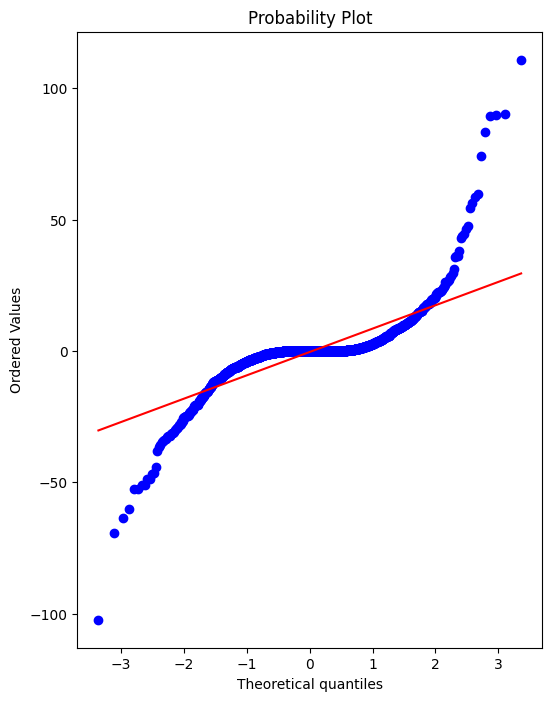

In [16]:
#we can see that the probability plot of the residuals indictes a cubic function
fig, ax = plt.subplots(figsize=(6,8))
_ = sp.stats.probplot(eval_df['residuals'], plot=ax)

plt.show()